# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [12]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

43940


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [13]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [14]:
import seaborn as sns
import scanpy as sc

## 1.1 Define output folder

In [15]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\Cis_chromosome'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')


Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Cis_chromosome\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Cis_chromosome\figures.


## 1.2 setting up plotting parameters

In [16]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rc('font', family='serif')
plt.rc('font', serif='Arial')


# Other required plotting parameters
_dpi = 300
_font_size = 7.5
_page_width = 5.5

sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=_dpi/2, dpi_save=_dpi, frameon=False, 
                              figsize=(_page_width/2, _page_width/2), fontsize=_font_size, facecolor='white', transparent=True)
sc.settings.figdir = output_figure_folder

In [17]:
# cell labels from RNA-MERFISH and celltype prediction
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]
# cell palette from RNA-MERFISH UMAP and stats
celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}


In [18]:
# this is the plotting order noted based on the snRNA transcriptional acitivty;
# we'd use this for all the graphs in this notebook
# use the snRNA data below (# section 3.1.1) if needs to re-calculate
sorted_cellplot_order = ['Micro', 'Oligo', 'Endo', 'OPC', 'Astro', 'Vip', 'Lamp5',
                  'L5/6 NP', 'Sst', 'Sncg', 'Pvalb', 'L4/5 IT', 'L6 CT',
                  'L6 IT', 'L6b', 'L2/3 IT', 'L5 IT', 'L5 ET']

# 2. Load codebook

## Codebook

**Codebook** example from [codebook_link](../0_locus_annotation/resources/MERFISH_loci_adjacent_genes_tss_more_res.csv)

In [19]:
# load codebook
# L drive is Crick Pu_SSD_0
codebook_save_folder=r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin\resources'

# Load sorted codebook (allows direct matrix slicing) with cell type info
# Load codebook (then sort to allow direct matrix slicing) with cell type info

codebook_fname = os.path.join(codebook_save_folder,'MERFISH_loci_adjacent_genes_tss_more_res.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


# 3. Load contact dict


Data below can be generated from the notebook as:

[preprocess/2_dna_merfish/scripts/2_spot_pick/5_summarize_jie_to_dict_contact750](../../preprocess/2_dna_merfish/scripts/2_spot_pick/5_summarize_jie_to_dict_contact750.ipynb)

In [20]:
postanalysis_folder_CW = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0312'

class_2_contact_filename = os.path.join(postanalysis_folder_CW, 'subclass_2_contactDict_750.pkl')
print(class_2_contact_filename)
if os.path.exists(class_2_contact_filename):
    print("Loading contact")
    class_2_contactDict = np.load(class_2_contact_filename, allow_pickle=True)

\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0312\subclass_2_contactDict_750.pkl
Loading contact


# 4. Summarize insulation

In [21]:
from ImageAnalysis3.structure_tools import distance
#codebook_df = df_refgen.copy(deep=True)
sel_codebook = codebook_df

sort_by_region=False
chr_2_indices, chr_2_orders = distance.Generate_PlotOrder(codebook_df, codebook_df, sort_by_region=False)## load codebook

In [22]:
from matplotlib.colors import LogNorm
import ImageAnalysis3.structure_tools.distance as distance

#from ImageAnalysis3.domain_tools.distance import _sliding_window_dist
import insulation
reload(insulation)

from insulation import sliding_window_insulation, sliding_window_insulation_by_gene_dist
from scipy.signal import find_peaks

## Insulation profile across selected chromosome

### window size at 16 bins centered at the targeted bin (aka > 10-20 Mb)

C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_43940\824212549.py:36: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(grid[_idx])
meta NOT subset; don't know how to subset; dropped


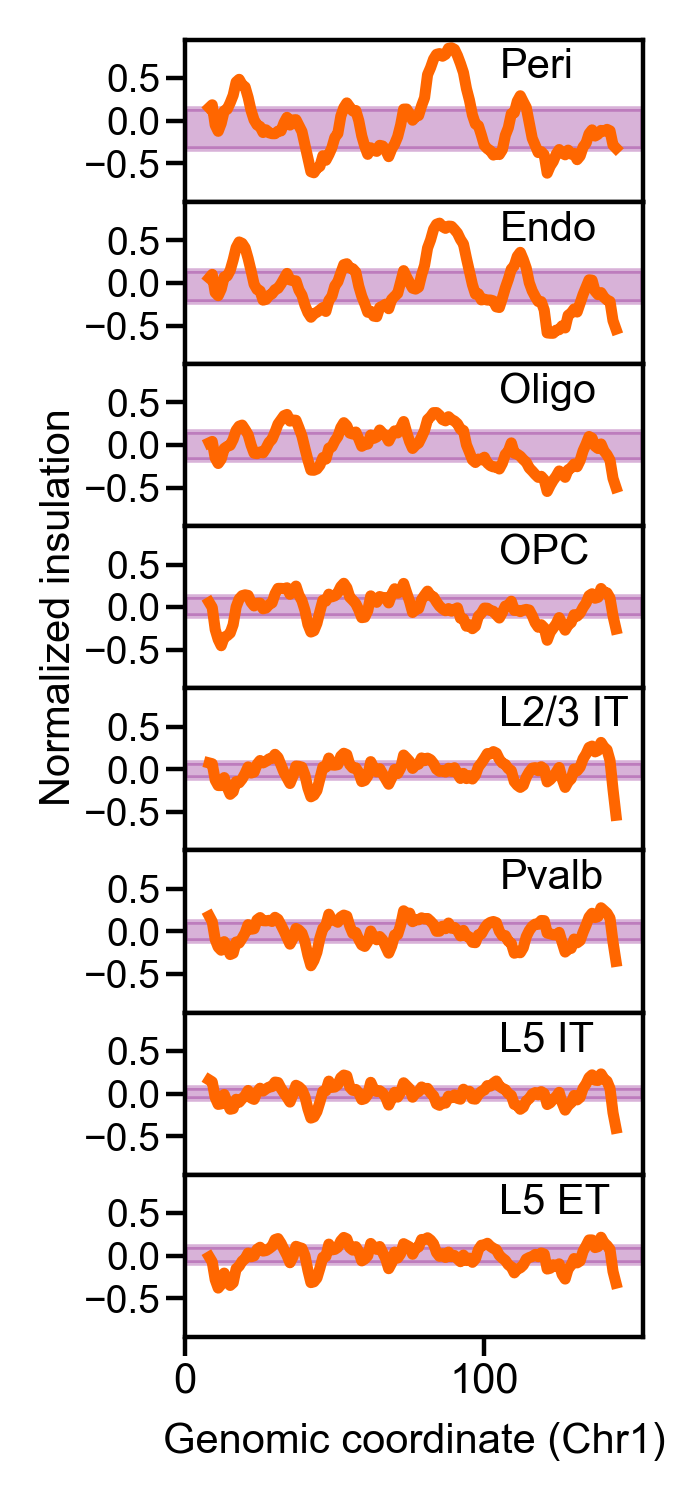

In [38]:
%matplotlib inline


sel_cellgroups = ['Peri','Endo','Oligo','OPC','L2/3 IT','Pvalb','L5 IT','L5 ET']
chosen_chrom = '1'
#chosen_chrom = '2'

wd_size = 16

#plt.style.use('dark_background')


fig, axes = plt.subplots(
                         figsize=(_page_width/3.75,_page_width/3.75/2.75*len(sel_cellgroups)), 
                         sharex=True, sharey=False, dpi=200)

grid = plt.GridSpec(len(sel_cellgroups), 1,  hspace=0., wspace=0.)

#for _class in class_2_contactDict.keys():
for _idx, _class in enumerate(sel_cellgroups):
    summary_dict = class_2_contactDict[_class]
    _cis_mat, chr_edges, chr_names = distance.assemble_ChrDistDict_2_Matrix(
            summary_dict, codebook_df, 
            sel_codebook=codebook_df, 
            use_cis=True, sort_by_region=sort_by_region,
        )

    _chr_indices = chr_2_indices[chosen_chrom]
    cis_mat_chr = _cis_mat[:,_chr_indices]
    cis_mat_chr = cis_mat_chr[_chr_indices,:]

    distance_wd_dists = sliding_window_insulation(cis_mat_chr, _wd=wd_size, 
                                             _dist_metric='normed_insulation')


    ax = plt.subplot(grid[_idx])

    distance_peaks = find_peaks(-distance_wd_dists, distance=5, 
                                prominence=0.05, width=1)
    # invert because the sliding_window_insulation is from intra-inter: high intra gives high value 
    ax.plot(distance_wd_dists, color=[1,0.4,0], 
             #label=f'{_class}', 
            linewidth=2)
    #for _p in distance_peaks[0]:
        #ax.vlines(_p, -1, 1, linewidth=1.5, linestyles="dotted",color='k' )

    #print(len(distance_peaks[0]))
    ins_IQR = np.nanpercentile(distance_wd_dists,75)-np.nanpercentile(distance_wd_dists,25)
    #print(_class, f'{len(distance_peaks[0])} peaks', ins_IQR)

    ax.fill_between(x = [0,len(cis_mat_chr)],
                    y1=np.nanpercentile(distance_wd_dists,25), 
                     y2=np.nanpercentile(distance_wd_dists,75), 
                    alpha =0.3,
                     color='purple' )
    
    ax.annotate(f'{_class}',(105,0.5), fontsize=_font_size)
    ax.tick_params(axis='y', pad=1,labelsize=_font_size-0.5) 
    ax.grid(False)

    plt.ylim([-.95,.95])
    plt.xlim([0,len(cis_mat_chr)])
    if _class == 'OPC':
        ax.set_ylabel('Normalized insulation',fontsize=_font_size, rotation = 90, labelpad= 1, loc='center')
    if _class == 'L5 ET':
        ax.set_xlabel(f'Genomic coordinate (Chr{chosen_chrom})',fontsize=_font_size)
        ax.tick_params(axis='x', rotation=0, pad=1,labelsize=_font_size) 
    else:
        ax.tick_params(axis='x', rotation=0, pad=0,labelsize=0,length=0) 
    #fig.savefig(figure_folder+os.sep+'TADsInsulation_medianDistance.png')


plt.savefig(os.path.join(output_figure_folder, f'Contact_insulation_across_celltypes_wd{wd_size}_chr{chosen_chrom}.pdf'), 
            transparent=True, dpi=300, bbox_inches='tight')    
plt.show()

## Summary for all chromosomes

In [39]:
all_chroms = np.array([c for c in np.unique(codebook_df['chr']) if c!= 'Y'])
all_chroms 

array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '3', '4', '5', '6', '7', '8', '9', 'X'], dtype='<U2')

In [40]:
ins_res_dict = {'celltype':[], 'insulation_iqr':[], 'peak_number':[], 'chr':[], 'window_size':[]}
wd_size_list = [16,4]

import tqdm

for _class in tqdm.tqdm(class_2_contactDict.keys()):
    print (f'Analyze {_class}')
    # get contact maps
    summary_dict = class_2_contactDict[_class]
    _cis_mat, chr_edges, chr_names = distance.assemble_ChrDistDict_2_Matrix(
            summary_dict, codebook_df, 
            sel_codebook=codebook_df, 
            use_cis=True, sort_by_region=sort_by_region,
                                                        )

    for chosen_chrom in all_chroms:
        # slice contact maps for chromosome
        _chr_indices = chr_2_indices[chosen_chrom]
        cis_mat_chr = _cis_mat[:,_chr_indices]
        cis_mat_chr = cis_mat_chr[_chr_indices,:]
        # estimate insulation and peaks ('large megabase domains')
        
        for wd_size in wd_size_list:
            distance_wd_dists = sliding_window_insulation(cis_mat_chr, _wd=wd_size, 
                                                     _dist_metric='normed_insulation')

            distance_peaks = find_peaks(-distance_wd_dists, distance=5, 
                                    prominence=0.05, width=1)

            ins_IQR = np.nanpercentile(distance_wd_dists,75)-np.nanpercentile(distance_wd_dists,25)
            peak_num = len(distance_peaks[0])

            # append result
            ins_res_dict['celltype'].append(_class)
            ins_res_dict['insulation_iqr'].append(ins_IQR)
            ins_res_dict['peak_number'].append(peak_num)
            ins_res_dict['chr'].append(chosen_chrom)
            ins_res_dict['window_size'].append(wd_size)



  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

Analyze Oligo



  5%|███▉                                                                               | 1/21 [00:02<00:40,  2.03s/it]

Analyze L5 IT


C:\Users\shiwei\Documents\AnalysisTool_Chromatin\insulation.py:50: RuntimeWarning: invalid value encountered in log2
  norm_dists = np.log2(dists/mean_dist)
 10%|███████▉                                                                           | 2/21 [00:04<00:38,  2.04s/it]

Analyze Micro



 14%|███████████▊                                                                       | 3/21 [00:06<00:36,  2.03s/it]

Analyze Peri



 19%|███████████████▊                                                                   | 4/21 [00:08<00:34,  2.03s/it]

Analyze Endo



 24%|███████████████████▊                                                               | 5/21 [00:10<00:32,  2.03s/it]

Analyze Astro



 29%|███████████████████████▋                                                           | 6/21 [00:12<00:30,  2.03s/it]

Analyze OPC



 33%|███████████████████████████▋                                                       | 7/21 [00:14<00:28,  2.02s/it]

Analyze L6 CT



 38%|███████████████████████████████▌                                                   | 8/21 [00:16<00:26,  2.02s/it]

Analyze L5 ET



 43%|███████████████████████████████████▌                                               | 9/21 [00:18<00:24,  2.01s/it]

Analyze L5/6 NP



 48%|███████████████████████████████████████                                           | 10/21 [00:20<00:22,  2.02s/it]

Analyze Pvalb



 52%|██████████████████████████████████████████▉                                       | 11/21 [00:22<00:20,  2.02s/it]

Analyze L6 IT



 57%|██████████████████████████████████████████████▊                                   | 12/21 [00:24<00:18,  2.02s/it]

Analyze Lamp5



 62%|██████████████████████████████████████████████████▊                               | 13/21 [00:26<00:16,  2.02s/it]

Analyze L6b



 67%|██████████████████████████████████████████████████████▋                           | 14/21 [00:28<00:14,  2.01s/it]

Analyze Sst



 71%|██████████████████████████████████████████████████████████▌                       | 15/21 [00:30<00:12,  2.02s/it]

Analyze SMC



 76%|██████████████████████████████████████████████████████████████▍                   | 16/21 [00:32<00:10,  2.02s/it]

Analyze L4/5 IT



 81%|██████████████████████████████████████████████████████████████████▍               | 17/21 [00:34<00:08,  2.01s/it]

Analyze L2/3 IT



 86%|██████████████████████████████████████████████████████████████████████▎           | 18/21 [00:36<00:06,  2.02s/it]

Analyze Vip



 90%|██████████████████████████████████████████████████████████████████████████▏       | 19/21 [00:38<00:04,  2.01s/it]

Analyze Sncg



 95%|██████████████████████████████████████████████████████████████████████████████    | 20/21 [00:40<00:02,  2.02s/it]

Analyze VLMC


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:42<00:00,  2.02s/it]


In [41]:
ins_res_df = pd.DataFrame(ins_res_dict)
ins_res_df

,celltype,insulation_iqr,peak_number,chr,window_size
0,Oligo,0.328812,11,1,16
1,Oligo,0.706506,17,1,4
2,Oligo,0.299610,7,10,16
3,Oligo,0.656588,18,10,4
4,Oligo,0.250850,8,11,16
...,...,...,...,...,...
835,VLMC,0.840080,13,8,4
836,VLMC,0.296280,7,9,16
837,VLMC,0.777790,15,9,4
838,VLMC,0.590965,4,X,16


## Plot

In [42]:
# Required plotting setting
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')
_font_size = 7.5

from ImageAnalysis3.figure_tools import _dpi,_single_col_width,_double_col_width,_single_row_height,_ref_bar_length, _ticklabel_size,_ticklabel_width,_font_size

meta NOT subset; don't know how to subset; dropped


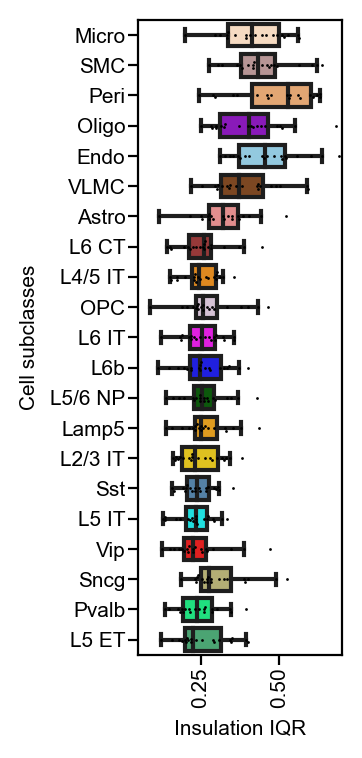

In [63]:



# order based on long-range distance medians
sorted_cellplot_order = ['Micro', 'SMC', 'Peri', 'Oligo', 'Endo', 'VLMC', 'Astro', 'L6 CT',
       'L4/5 IT', 'OPC', 'L6 IT', 'L6b', 'L5/6 NP', 'Lamp5', 'L2/3 IT', 'Sst',
       'L5 IT', 'Vip', 'Sncg', 'Pvalb', 'L5 ET']


#fig, ax = plt.subplots(figsize=(8,4),dpi=100)
fig, ax = plt.subplots(
                         figsize=(_page_width/4.2,_page_width/3.95*3), 
                         sharex=True, sharey=False, dpi=100)
#grid = plt.GridSpec(len(wd_size_list), 1,  hspace=0., wspace=0.)


for _idx, _window_size in enumerate(wd_size_list[:1]):
    plot_df = ins_res_df[ins_res_df['window_size']==_window_size]
    #axes = plt.subplot(grid[_idx])

    sns.boxplot(plot_df, x = 'insulation_iqr', y='celltype', order=sorted_cellplot_order, 
                width=0.75, 
                palette=celltype_palette,
                fliersize=0,
                whis=[0,95],
                orient="h",
                ax= ax)
    sns.swarmplot(plot_df, x = 'insulation_iqr', y='celltype', order=sorted_cellplot_order,  
                  ax= ax, 
                  s= 1, 
                  legend=False, 
                  alpha=1,
                  color ='black',
                  orient="h",
                  #hue = 'chr',
                 )
    
    ax.tick_params(axis='y', pad=1, labelsize=_font_size) 
    if _idx==0:
        ax.set_ylabel('Cell subclasses',fontsize=_font_size)
        ax.tick_params(axis='x', rotation=90, pad=1, labelsize=_font_size) 
    else:
        ax.set_xlabel('',fontsize=0)
        ax.set_ylabel('',fontsize=0)
        ax.tick_params(axis='x', rotation=0, labelsize=0,length=0) 

plt.xlim([0.05,0.7])
plt.xlabel('Insulation IQR',fontsize=_font_size,)
ax.grid(False)
plt.savefig(os.path.join(output_figure_folder, f'Contact_insulation_summary_across_celltypes.pdf'), 
            transparent=True, dpi=300, bbox_inches='tight') 


plt.show()